# Social acceptance of wind and impact on deployment

In [2313]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.stats import truncnorm, linregress
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from typing import Type
import random
import statsmodels.formula.api as st_mdl
from math import pi, exp, ceil
import seaborn as sns
import time
%matplotlib inline

## Setting up the environment

In [2314]:
# Read Illinois shape file and create a geopanda data frame
il = gpd.read_file('./ilinois2/2010_Illinois_County_TotalPopulationDensity.shp')
df = pd.DataFrame(il)
geo_df = gpd.GeoDataFrame(df)
geo_df.head()

,TotPopDens,County,State,TotPopNum,AREAsqmi,FIPS_Cnty,geometry
0,37.229000,Jo Daviess,Illinois,22678.0,609.147602,17085,"POLYGON ((-89.92558 42.50751, -89.92466 42.458..."
1,86.183800,Stephenson,Illinois,47711.0,553.595891,17177,"POLYGON ((-89.40308 42.50300, -89.40128 42.463..."
2,573.309998,Winnebago,Illinois,295266.0,515.019710,17201,"POLYGON ((-89.36452 42.50294, -89.31850 42.502..."
3,510.584991,McHenry,Illinois,308760.0,604.717660,17111,"POLYGON ((-88.30162 42.49791, -88.19713 42.498..."
4,194.406006,Boone,Illinois,54165.0,278.618125,17007,"POLYGON ((-88.77372 42.49575, -88.77185 42.495..."


In [2315]:
# Initialize random seed
np.random.seed(0)

def trunc_normal_distrib_draw(
        min_distrib: float, max_distrib: float, mean: float,
        standard_deviation: float) -> float:
    """
    Draw a value from a truncated normal distribution.
    :param min_distrib: minimum of the range from where to draw.
    :param max_distrib: maximum of the range from where to draw.
    :param mean: mean of the distribution.
    :param standard_deviation: standard deviation of the distribution.
    :return: drawn value.
    """
    a = (min_distrib - mean) / standard_deviation
    b = (max_distrib - mean) / standard_deviation
    loc = mean
    scale = standard_deviation
    distribution = truncnorm(a, b, loc, scale)
    draw = float(distribution.rvs(1))
    return draw

# Bessette & Mills approximate data (using truncated normal distribution based on Bessette & Mills summary statistics 
# and not actual data)
geo_df['percent_prod'] = np.nan
geo_df['percent_prod'] = geo_df['percent_prod'].apply(lambda x: trunc_normal_distrib_draw(0, 100, 25, 8))
geo_df['percent_rep'] = np.nan
geo_df['percent_rep'] = geo_df['percent_rep'].apply(lambda x: trunc_normal_distrib_draw(0, 100, 63, 7))
geo_df['amenities'] = np.nan
geo_df['amenities'] = geo_df['amenities'].apply(lambda x: trunc_normal_distrib_draw(1, 4, 2.2, 0.72))
geo_df['illinois'] = np.where(df['State'] == 'Illinois', True, False)
intercept = 9.77
percent_prod_beta = -0.145
percent_rep_beta = -0.077
amenity_beta = 1.599
illinois_beta = 2.4

# Bessette & Mills approximate model (only keeping significant independent variables)
geo_df['contention'] = (intercept + percent_prod_beta * geo_df['percent_prod'] + 
                        percent_rep_beta * geo_df['percent_rep'] + amenity_beta * geo_df['amenities'] +
                        illinois_beta * geo_df['illinois'])

# Average wind speed placeholder (m/s)
geo_df['wind_speed'] = np.nan
geo_df['wind_speed'] = geo_df['wind_speed'].apply(lambda x: trunc_normal_distrib_draw(4, 6, 5, 1))

# Maximum of new wind turbines placeholder
# Assumes only 5% of total area is available
# Assumes a new wind plant turbine takes 2/10 of a square mile 
# (https://sciencing.com/much-land-needed-wind-turbines-12304634.html)
land_use_turbine = 2 / 10  # square mile / turbine
geo_df['percent_area_avbl'] = np.nan
geo_df['percent_area_avbl'] = geo_df['percent_area_avbl'].apply(lambda x: trunc_normal_distrib_draw(0, 0.5, 0.025, 0.01))
geo_df['max_n_turbine'] = (geo_df['AREAsqmi'] * geo_df['percent_area_avbl'] / land_use_turbine).astype(int)

# Correct model results so that contention is between 0 and 10
geo_df['contention'] = np.where(geo_df['contention'] > 10, 10, geo_df['contention'])
geo_df['contention'] = np.where(geo_df['contention'] < 0, 0, geo_df['contention'])

geo_df.head()

,TotPopDens,County,State,TotPopNum,AREAsqmi,FIPS_Cnty,geometry,percent_prod,percent_rep,amenities,illinois,contention,wind_speed,percent_area_avbl,max_n_turbine
0,37.229000,Jo Daviess,Illinois,22678.0,609.147602,17085,"POLYGON ((-89.92558 42.50751, -89.92466 42.458...",25.989419,67.400188,1.143487,True,5.040155,4.322685,0.027972,85
1,86.183800,Stephenson,Illinois,47711.0,553.595891,17177,"POLYGON ((-89.40308 42.50300, -89.40128 42.463...",29.554845,75.436670,1.322268,True,4.190231,4.140852,0.007385,20
2,573.309998,Winnebago,Illinois,295266.0,515.019710,17201,"POLYGON ((-89.36452 42.50294, -89.31850 42.502...",27.091378,58.251069,2.558025,True,7.846699,5.396172,0.004805,12
3,510.584991,McHenry,Illinois,308760.0,604.717660,17111,"POLYGON ((-88.30162 42.49791, -88.19713 42.498...",25.910117,64.344508,2.158445,True,6.909859,4.031738,0.023296,70
4,194.406006,Boone,Illinois,54165.0,278.618125,17007,"POLYGON ((-88.77372 42.49575, -88.77185 42.495...",23.470047,64.629605,2.300297,True,7.468539,5.480946,0.010524,14


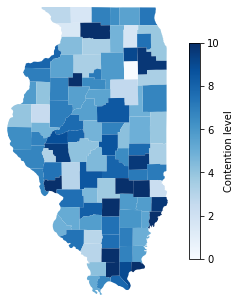

In [2316]:
# Plot contention on a map of Illinois

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
color_scale = 'Blues'

ax.axis('off')
ax.margins(0)
vmin, vmax = 0, 10  # Contention is between 0 and 10 
sm = plt.cm.ScalarMappable(cmap=color_scale, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, fraction=0.025, label='Contention level')

geo_df.plot(ax=ax, column='contention', cmap=color_scale)
plt.savefig('WindAcceptance.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

## Turbines data

In [2317]:
turbines_data = pd.read_csv('uswtdb_v4_2_20211101.csv')
turbines_data = turbines_data[turbines_data['t_state'] == 'IL'] 
min_n_turbines = turbines_data['p_tnum'].min()
max_n_turbines = turbines_data['p_tnum'].max()
mean_n_turbines = turbines_data['p_tnum'].mean()
std_n_turbines = turbines_data['p_tnum'].std()
min_t_rd = turbines_data['t_rd'].min()
max_t_rd = turbines_data['t_rd'].max()
mean_t_rd = turbines_data['t_rd'].mean()
std_t_rd = turbines_data['t_rd'].std()
t_rd_mdl_result = st_mdl.ols(formula="t_rd ~ p_year", data=turbines_data).fit().params
int_t_rd_mdl, coef_t_rd_mdl = t_rd_mdl_result['Intercept'], t_rd_mdl_result['p_year']
project_data = turbines_data.groupby('p_name').mean()
project_data = project_data.sort_values(by=['p_year'])
yearly_project_count = project_data['p_year'].value_counts(sort=False).to_frame()
yearly_project_count = yearly_project_count.sort_index(ascending=True)
yearly_project_count['cum_num_project'] = yearly_project_count['p_year'].cumsum()
yearly_project_count.reset_index(level=0, inplace=True)
p_mdl_result = st_mdl.ols(formula="cum_num_project ~ index", data=yearly_project_count).fit().params
yearly_projects = int(p_mdl_result['index'])
starting_year = turbines_data['p_year'].max()

## Setting up model & agents

### Model

In [2318]:
seed = 0
column_names = geo_df['County'].unique()
end_year = 2035
states = list(range(0, int(end_year - starting_year), 1))
# Create the Q-table with a number of columns (actions) equal to the number of counties 
# (siting choices) and the number of rows (states) equal to the number of simulation steps
q_table = pd.DataFrame(0, index=states, columns=column_names)
episodes = 1
epsilon = 0.5
start_epsilon_decaying = 1
end_epsilon_decaying_factor = 2
end_epsilon_decaying = episodes / end_epsilon_decaying_factor
epsilon_decay_value = epsilon / (end_epsilon_decaying - start_epsilon_decaying)

In [2319]:
class WindAcceptanceModel(Model):
    def __init__(self,
                 seed: int = seed,
                 num_agents_init: int = yearly_projects,
                 environment: Type[gpd.GeoDataFrame] = geo_df,
                 q_table: Type[gpd.GeoDataFrame] = q_table,
                 states: list = states,
                 learning_rate: float = 0.1,
                 discount: float = 0.95,
                 episodes: int = episodes,
                 epsilon: float = epsilon,
                 # source of x lines below is: 
                 # http://solidwize.com/wp-content/uploads/2013/07/7-Understanding-the-Wind-Power-Equation.pdf
                 power_coeff: float = 0.5,
                 air_density: float = 1.225,
                 starting_year: int = int(starting_year),
                 end_year: int = end_year,
                 time_delay: int = 1,
                 penalty: int = 1,
                 reward_correction: int = 1
                ) -> None:
        """
        Initiate model from input data.
        :param seed: number used to initialize the random generator.
        :param num_agents: number of agents.
        """
        # Assign inputs to instance variables
        self.seed = seed
        self.num_agents_init = num_agents_init
        self.environment = environment
        self.q_table = q_table
        #print(self.q_table)
        #self.q_table = self.q_table.sample(frac=1)  # .reset_index(drop=False)
        #self.q_table = self.q_table.T
        #print(self.q_table)
        self.states = states
        self.learning_rate = learning_rate
        self.discount = discount
        self.episodes = episodes
        self.epsilon = epsilon
        self.power_coeff = power_coeff
        self.air_density = air_density
        self.starting_year = starting_year
        self.end_year = end_year
        self.time_delay = time_delay
        self.penalty = penalty
        self.reward_correction = reward_correction

        # Initialize random seed
        random.seed(self.seed)
        self.reset_randomizer(self.seed)
        
        # Create model variables
        self.agent_id = 0
        self.schedule = RandomActivation(self)
        self.q_table['delay'] = 0
        self.min_t_rd = min_t_rd
        self.max_t_rd = max_t_rd
        self.mean_t_rd = mean_t_rd
        self.std_t_rd = std_t_rd
        self.clock = 0
        self.environment['n_turbines_installed'] = 0
        self.environment['cumul_power_generation'] = 0
        self.tot_turbines_installed = dict()
        self.cumul_power_generation = dict()
        self.hours_in_year = 365.25 * 24  # 365.25 days/year and 24 hours/day
        self.tot_cumul_power_generation = 0
        self.tot_yearly_power_generation = 0
        self.previous_cum_p_gen = 0
        self.max_power_capacity = (
            self.power_coeff * self.air_density * pi * (
            (self.max_t_rd + p_mdl_result['index'] * (self.end_year - self.starting_year)) / 2)**2 * 
            self.environment['wind_speed'].max()**3 / 1E6)
        self.contention_delay = 0
        self.total_reward = 0
        self.max_yearly_power_generation = self.compute_max_power_generation(
            self.max_t_rd, yearly_projects, max_n_turbines)
        self.power_gen_reward = 0
        self.max_delay = 0
        
        # Create initial agents
        self.adding_agents(self.num_agents_init, self.schedule, WindDeveloperAgent)
        
        # Create data collectors
        self.model_reporters = {
            "Clock": "clock",
            "Number of turbines installed": "tot_turbines_installed",
            "Cumulative power generation (TWh)": "cumul_power_generation",
            "Total cumulative power generation (TWh)": "tot_cumul_power_generation", 
            "Delays due to contention (years)": "contention_delay"}
        self.data_collector = DataCollector(
            model_reporters=self.model_reporters)
    
    def adding_agents(self, num_agents: int, schedule: Type[RandomActivation], 
                      agent_class: Type[Agent]) -> None:
        """
        Add agents to the schedule.
        :param num_agents: number of agents to add
        :param schedule: the schedule
        :param agent_class: the agent class
        """
        for agent in range(num_agents):
            a = agent_class(self.agent_id, self)
            schedule.add(a)
            self.max_delay += self.time_delay
            self.agent_id += 1
    
    @staticmethod
    def increase_rotor_radius(min_t_rd, max_t_rd, mean_t_rd, std_t_rd, p_mdl_result):
        min_t_rd += p_mdl_result['index']
        max_t_rd += p_mdl_result['index']
        mean_t_rd += p_mdl_result['index']
        std_t_rd += p_mdl_result['index']
        return min_t_rd, max_t_rd, mean_t_rd, std_t_rd
    
    @staticmethod
    def shuffle_panda_columns(df_in):
        cols = list(df_in.columns.values)
        random.shuffle(cols)
        df_in = df_in.set_axis(cols, axis=1, inplace=True)
        return df_in
    
    def compute_max_power_generation(self, max_t_rd, yearly_projects, max_n_turbines):
        local_wind_speed = self.environment['wind_speed'].max()
        power = (self.power_coeff * self.air_density * pi * (self.max_t_rd / 2)**2 * 
                            local_wind_speed**3) / 1E6
        # Convert MWh to TWh
        max_yearly_power_generation = (
            yearly_projects * max_n_turbines * power * self.hours_in_year / 1E6)
        return max_yearly_power_generation
    
    def extract_environment_variables(self):
        self.tot_turbines_installed = self.environment.set_index('County')['n_turbines_installed'].to_dict()
        self.cumul_power_generation = self.environment.set_index('County')['cumul_power_generation'].to_dict()
        
    def step(self) -> None:
        """
        Advance the model by one step
        """
        self.tot_cumul_power_generation = self.environment['cumul_power_generation'].sum()
        self.tot_yearly_power_generation = self.tot_cumul_power_generation - self.previous_cum_p_gen
        self.power_gen_reward = self.tot_cumul_power_generation / self.max_yearly_power_generation
        self.previous_cum_p_gen = self.tot_cumul_power_generation
        self.schedule.step()
        self.min_t_rd, self.max_t_rd, self.mean_t_rd, self.std_t_rd = (
            self.increase_rotor_radius(self.min_t_rd, self.max_t_rd, 
                                       self.mean_t_rd, self.std_t_rd, p_mdl_result))
        self.max_yearly_power_generation += self.compute_max_power_generation(
            self.max_t_rd, yearly_projects, max_n_turbines)
        self.extract_environment_variables()
        self.data_collector.collect(self)
        self.adding_agents(yearly_projects, self.schedule, WindDeveloperAgent)
        self.clock += 1

### Agents

In [2320]:
class WindDeveloperAgent(Agent):
    def __init__(self, unique_id, model) -> None:
        super().__init__(unique_id, model)
        """
        Creation of new agent.
        """
        self.delay = 0
        self.current_state = self.model.clock
        self.siting_status = 'non-sited'
        self.n_turbines = int(trunc_normal_distrib_draw(min_n_turbines, max_n_turbines, 
                                                    mean_n_turbines, std_n_turbines))
        self.t_rd = trunc_normal_distrib_draw(self.model.min_t_rd, self.model.max_t_rd, 
                                              self.model.mean_t_rd, self.model.std_t_rd)
        self.power = 0
        self.site = np.nan
        
    def place_turbines(self):
        if self.delay == 0:
            new_state = min(self.current_state + 1, 
                            (self.model.end_year - self.model.starting_year - 1))
            if np.random.random() > self.model.epsilon:
                maximums = self.model.q_table.idxmax(axis=1)
                action = maximums.loc[self.current_state]
            else:
                action = random.choice(self.model.q_table.columns)
            if action != 'delay':
                index_action = self.model.environment.index[self.model.environment['County'] == action]
                self.model.environment.loc[index_action, 'n_turbines_installed'] = (
                    self.model.environment.loc[index_action, 'n_turbines_installed'] + self.n_turbines)
            else:
                self.siting_status = 'delayed'
                self.delay += self.model.time_delay
                self.model.contention_delay += self.model.time_delay
            # Contention as a negative reward and risk of delay
            contention_penalty = 0
            if action != 'delay':
                contentions = self.model.environment[self.model.environment['County'] == action]
                # Normalize contention between 0 and 1 (max contention is 10)
                contention = contentions.iloc[0]['contention'] / 10
                if np.random.random() > contention:
                    pass
                    #contention_penalty = contention
                else:
                    self.delay += self.model.time_delay
                    #self.siting_status = 'delayed'
                    contention_penalty = contention
                    self.model.contention_delay += self.model.time_delay
            reward = self.reward_calculation(action, contention_penalty)
            current_q = self.model.q_table.loc[self.current_state, action]
            maximums = self.model.q_table.max(axis=1)
            max_future_q = maximums.loc[new_state]
            new_q = ((1 - self.model.learning_rate) * current_q + self.model.learning_rate * 
                     (reward + self.model.discount * max_future_q))
            self.model.q_table.loc[self.current_state, action] = new_q
            self.current_state = new_state
            if self.siting_status != 'delayed':
                self.site = action
                self.siting_status = 'sited'
        else:
            # Pass to next state (time step)
            self.current_state = min(self.current_state + 1, 
                                     (self.model.end_year - self.model.starting_year - 1))
    
    def reward_calculation(self, action, contention_penalty):
        # If wind developper delay siting, a negative reward is returned
        if action != 'delay' and self.siting_status != 'delayed':
            # Power generated
            local_wind_speeds = self.model.environment[self.model.environment['County'] == action]
            local_wind_speed = local_wind_speeds.iloc[0]['wind_speed']
            self.power = (self.model.power_coeff * self.model.air_density * pi * (self.t_rd / 2)**2 * 
                            local_wind_speed**3) / 1E6  # in MW
            power_reward = self.power / self.model.max_power_capacity
            power_n_contention_reward = power_reward - contention_penalty
            # Crowding level as a negative reward
            index_action = self.model.environment.index[self.model.environment['County'] == action]
            existing_turbines = int(self.model.environment.loc[index_action, 'n_turbines_installed'])
            max_turbines = int(self.model.environment.loc[index_action, 'max_n_turbine'])
            crowding_level = (existing_turbines - max_turbines) / max_turbines
            crowding_level = 1 / (1 + exp(-1 * crowding_level))
            # Power generation reward
            p_gen_reward = self.model.power_gen_reward
            # Delay penalty
            delay_penalty = self.model.contention_delay / self.model.max_delay
            delay_penalty = 1 / (1 + exp(-1 * delay_penalty))
            if crowding_level < 0.5:
                reward = (p_gen_reward + self.model.reward_correction + 
                          power_n_contention_reward + crowding_level - delay_penalty)
            else:
                reward = (p_gen_reward + self.model.reward_correction + 
                          power_n_contention_reward - self.model.penalty - delay_penalty)
        else:
            reward = -1 * self.model.penalty - self.delay - contention_penalty  # prevent agents from delaying projects
        self.model.total_reward += reward
        return reward
    
    def update_cumul_power_generation(self):
        if self.delay == 0 and self.siting_status == 'sited':
            site = self.model.environment.index[self.model.environment['County'] == self.site]
            # Assumes wind turbines generate power every hour of the year at the average wind speed 
            # and convert MWh to TWh
            self.model.environment.loc[site, 'cumul_power_generation'] += (
                self.power * self.n_turbines * self.model.hours_in_year * (
                    (run.end_year - run.starting_year) - self.model.clock) / 1E6)
    
    def remove_agent(self):
        """
        Remove agent only if turbines are placed
        """
        if self.delay == 0:
            self.model.schedule.remove(self)
        else:
            self.delay -= self.model.time_delay

    def step(self) -> None:
        """
        Evolution of agent at each step
        """
        self.place_turbines()
        self.update_cumul_power_generation()
        self.remove_agent()

## Train reinforcement learning algorithm

Completion: 0.0% (or 0/500 episodes) in 4s
Completion: 10.0% (or 50/500 episodes) in 286s
Completion: 20.0% (or 100/500 episodes) in 726s
Completion: 30.0% (or 150/500 episodes) in 1159s
Completion: 40.0% (or 200/500 episodes) in 1615s
Completion: 50.0% (or 250/500 episodes) in 2029s
Completion: 60.0% (or 300/500 episodes) in 2432s
Completion: 70.0% (or 350/500 episodes) in 2890s
Completion: 80.0% (or 400/500 episodes) in 3346s
Completion: 90.0% (or 450/500 episodes) in 3776s


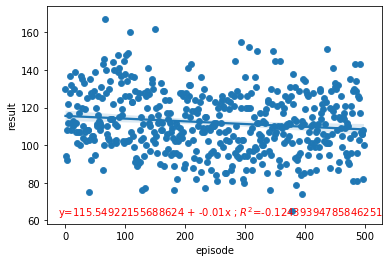

In [2321]:
episode_list = []
result_list = []
training = True
episodes = 500
epsilon = 0.5
start_epsilon_decaying = 1
end_epsilon_decaying_factor = 2
end_epsilon_decaying = episodes / end_epsilon_decaying_factor
epsilon_decay_value = epsilon / (end_epsilon_decaying - start_epsilon_decaying)

if training:
    t0 = time.time()
    for episode in range(episodes):
        seed = episode
        q_table = q_table.T.sample(frac=1).T
        run = WindAcceptanceModel(
            seed=seed,
            num_agents_init=yearly_projects,
            environment=geo_df,
            q_table=q_table,
            states=states,
            learning_rate=0.1,
            discount=0.95,
            episodes=episodes,
            epsilon=epsilon,
            power_coeff=0.5,
            air_density=1.225,
            starting_year=int(starting_year),
            end_year=2035,
            time_delay=1,
            penalty=1, 
            reward_correction=4)
        time_steps = run.end_year - run.starting_year  # Period of the simulation
        for time_step in range(time_steps):
            run.step()
        episode_list.append(episode)
        #result_list.append(run.tot_cumul_power_generation)
        result_list.append(run.contention_delay)
        #result_list.append(run.total_reward)
        if (end_epsilon_decaying >= episode >= start_epsilon_decaying):
            epsilon -= epsilon_decay_value
        t1 = time.time()
        if episode % (ceil(episodes / 10)) == 0:
            print(f'Completion: {episode / episodes * 100}% (or {episode}/{episodes} episodes) in {round(t1 - t0)}s')

    q_table.to_csv('q_table.csv')

    slope, intercept, r_value, p_value, std_err = linregress(episode_list, result_list)
    tips = pd.DataFrame(list(zip(episode_list, result_list)), columns =['episode', 'result'])
    fig, ax = plt.subplots()
    sns.scatterplot(data=tips, x="episode", y="result", ax=ax)
    sns.regplot(data=tips, x="episode", y="result", ax=ax)
    fig.text(0.15, 0.15, f'y={intercept} + {round(slope, 2)}x ; $R^2$={r_value}').set_color("red")
    plt.savefig('TrainingResults.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

## Analysis

### Running the trained model

In [2322]:
seed = 0
# Upload Q-table from training
q_table = pd.read_csv('q_table.csv', index_col=0)
# Number of replicates (to account for uncertainty)
replicates = 5
epsilon = 0
start_epsilon_decaying = 1
end_epsilon_decaying =simulationsilon_decay_value = 0
outputs = []

for replicate in range(replicates):
    seed = replicate
    run = WindAcceptanceModel(
        seed=seed,
        num_agents_init=yearly_projects,
        environment=geo_df,
        q_table=q_table,
        states=states,
        learning_rate=0.1,
        discount=0.95,
        episodes=episodes,
        epsilon=epsilon,
        power_coeff=0.5,
        air_density=1.225,
        starting_year=int(starting_year),
        end_year=2035,
        time_delay=1,
        penalty=1,
        reward_correction=1)
    time_steps = run.end_year - run.starting_year  # Period of the simulation
    for time_step in range(time_steps):
        run.step()
    simulation_outputs = run.data_collector.get_model_vars_dataframe()
    outputs.append(simulation_outputs)

merged_outputs = pd.concat(outputs)
tot_p_gen_n_delay = merged_outputs.groupby(['Clock']).mean()
num_t_installed = merged_outputs.drop(columns=['Total cumulative power generation (TWh)', 
                                       'Cumulative power generation (TWh)', 'Delays due to contention (years)'])
p_generation = merged_outputs.drop(columns=['Total cumulative power generation (TWh)', 
                                       'Number of turbines installed', 'Delays due to contention (years)'])

def extract_data_in_dict(df_in, name_column):
    intermediate_df = pd.concat([df_in.drop([name_column], axis=1), 
                                 df_in[name_column].apply(pd.Series)], axis=1)
    df_in = (df_in.merge(intermediate_df, on='Clock').drop(
        columns=[name_column]))
    df_out = df_in.melt(
        'Clock', var_name='County', value_name=name_column).groupby(
        ['Clock', 'County']).mean()
    return df_out

num_t_installed = extract_data_in_dict(num_t_installed, 'Number of turbines installed').round()
p_generation = extract_data_in_dict(p_generation, 'Cumulative power generation (TWh)')
num_t_n_p = num_t_installed.merge(p_generation, on=['Clock', 'County']).reset_index()
analysis_df = tot_p_gen_n_delay.merge(num_t_n_p, on='Clock')
analysis_df = analysis_df.merge(geo_df, on='County')
analysis_df = gpd.GeoDataFrame(analysis_df)

In [2323]:
analysis_df.to_csv('analysis_df.csv')
analysis_df.head()

,Clock,Total cumulative power generation (TWh),Delays due to contention (years),County,Number of turbines installed,Cumulative power generation (TWh),TotPopDens,State,TotPopNum,AREAsqmi,...,percent_prod,percent_rep,amenities,illinois,contention,wind_speed,percent_area_avbl,max_n_turbine,n_turbines_installed,cumul_power_generation
0,0,0.000000,3.2,Adams,0.0,0.0,78.238297,Illinois,67103.0,857.674848,...,18.57869,66.960726,1.987983,True,7.498898,4.880618,0.041572,178,642,0.0
1,1,3.040197,8.0,Adams,0.0,0.0,78.238297,Illinois,67103.0,857.674848,...,18.57869,66.960726,1.987983,True,7.498898,4.880618,0.041572,178,642,0.0
2,2,14.259700,14.6,Adams,0.0,0.0,78.238297,Illinois,67103.0,857.674848,...,18.57869,66.960726,1.987983,True,7.498898,4.880618,0.041572,178,642,0.0
3,3,26.419664,21.4,Adams,23.0,0.0,78.238297,Illinois,67103.0,857.674848,...,18.57869,66.960726,1.987983,True,7.498898,4.880618,0.041572,178,642,0.0
4,4,46.277091,30.2,Adams,94.0,0.0,78.238297,Illinois,67103.0,857.674848,...,18.57869,66.960726,1.987983,True,7.498898,4.880618,0.041572,178,642,0.0


### Overall 2050 results

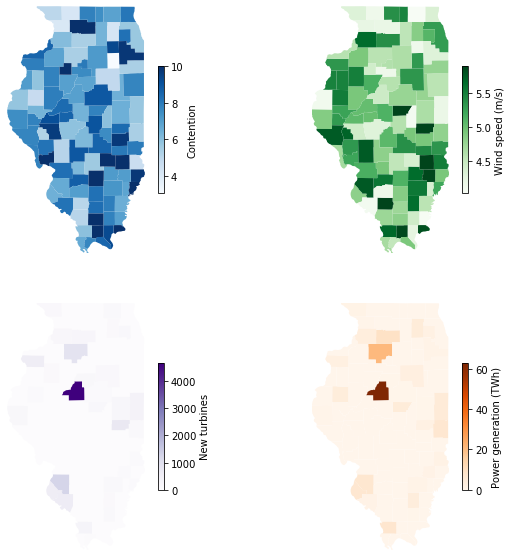

In [2324]:
input_df = analysis_df[analysis_df['Clock'] == analysis_df['Clock'].max()] 
num_plot = 0
variables = ['contention', 'wind_speed', 'Number of turbines installed', 'Cumulative power generation (TWh)']
titles = ['Contention', 'Wind speed (m/s)', 'New turbines', 'Power generation (TWh)']
fig = plt.figure(figsize=(10, 10))
for variable in variables:
    num_plot += 1
    ax = plt.subplot(2, 2, num_plot)
    color_scales = ['Blues', 'Greens', 'Purples', 'Oranges']
    ax.axis('off')
    ax.margins(0)
    input_df.plot(ax=ax, column=variable, cmap=color_scales[num_plot - 1])
    vmin, vmax = input_df[variable].min(), input_df[variable].max()
    sm = plt.cm.ScalarMappable(cmap=color_scales[num_plot - 1], norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, fraction=0.025, label=titles[num_plot - 1])
plt.savefig('WindAcceptance.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

### Time series results

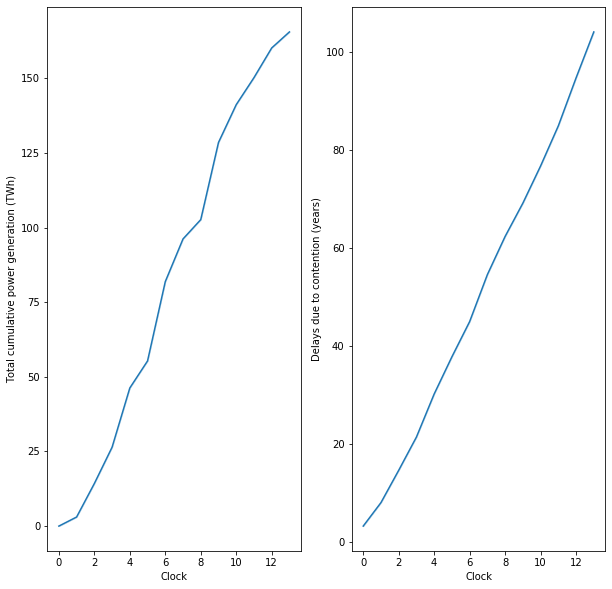

In [2325]:
# TODO: one line plot of total power generation and line plot of total delay ()
num_plot = 0
variables = ['Total cumulative power generation (TWh)', 'Delays due to contention (years)']
fig = plt.figure(figsize=(10, 10))
for variable in variables:
    num_plot += 1
    ax = plt.subplot(1, 2, num_plot)
    sns.lineplot(ax=ax, data=analysis_df, x="Clock", y=variables[num_plot - 1])

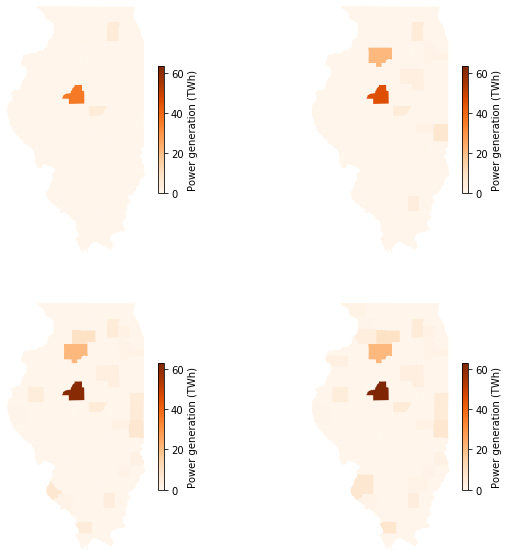

In [2326]:
num_plot = 0
periods = [0.25, 0.5, 0.75, 1]
fig = plt.figure(figsize=(10, 10))
for period in periods:
    input_df = analysis_df[analysis_df['Clock'] == round(analysis_df['Clock'].max() * period)]
    num_plot += 1
    ax = plt.subplot(2, 2, num_plot)
    ax.axis('off')
    ax.margins(0)
    vmin, vmax = analysis_df[
        'Cumulative power generation (TWh)'].min(), analysis_df[
        'Cumulative power generation (TWh)'].max()
    input_df.plot(ax=ax, column='Cumulative power generation (TWh)', cmap='Oranges', vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap='Oranges', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, fraction=0.025, label='Power generation (TWh)')
plt.savefig('WindAcceptance.png', bbox_inches='tight', tight_layout=True, pad_inches=0)

### Other results

In [2327]:
# Total production from: https://www.eia.gov/state/?sid=IL#tabs-4
# ROughly 10% of electricity is already from wind: https://www.eia.gov/state/analysis.php?sid=IL
production_target = (1 - 0.1) * 14.6  # in TWh
# Yearly production from new turbines
last_step = analysis_df['Clock'].max()
last_year = analysis_df[analysis_df['Clock'] == last_step].iloc[0][
    'Total cumulative power generation (TWh)']
scd_to_last_year = analysis_df[analysis_df['Clock'] == last_step - 1].iloc[0][
    'Total cumulative power generation (TWh)']
yearly_prod = last_year - scd_to_last_year
target_completion = int(round(yearly_prod / production_target * 100, 0))
print(f'The 100% zero-emission electricity goal by {2022 + last_step} is completed at {target_completion} %')

The 100% zero-emission electricity goal by 2035 is completed at 41 %
